# Optimization Project 2: Stock Portfolio Management

## Original Solution: Integer Programming

### Original Solution: Create the function to evaluate for any value of m 

In [1]:
def fund_builder(num_stocks):
    import pandas as pd
    import numpy as np
    import gurobipy as gp
    from gurobipy import GRB

    # Read the 2023 and 2024 data
    data_2023 = pd.read_csv('2023data.csv')
    data_2024 = pd.read_csv('2024data.csv')

    # Set 'Date' column as index and ensure 'NDX' column exists
    data_2023.set_index('Date', inplace=True)
    data_2024.set_index('Date', inplace=True)

    if 'NDX' not in data_2023.columns or 'NDX' not in data_2024.columns:
        raise ValueError("NDX column (index) is missing from the data.")

    # Calculate daily returns 
    returns_2023 = data_2023.pct_change()
    returns_2024 = data_2024.pct_change()

    # Compute the correlation matrix (ρ) of stock returns
    correlation_matrix = returns_2023.drop(columns=['NDX']).corr()

    returns_2023 = returns_2023.dropna(subset=['NDX'])
    returns_2024 = returns_2024.dropna(subset=['NDX'])

    # Separate index returns and stock returns
    index_returns_2023 = returns_2023['NDX']
    stock_returns_2023 = returns_2023.drop(columns=['NDX'])

    index_returns_2024 = returns_2024['NDX']
    stock_returns_2024 = returns_2024.drop(columns=['NDX'])

    # Get the list of stocks
    stocks = stock_returns_2023.columns.tolist()
    n = len(stocks)  # this should be 100

    # Number of stocks to select for the fund is m. Validate that m <= n
    m = min(num_stocks, n)

    # Formulate the integer program for stock selection
    model = gp.Model()

    # Decision variables
    y = model.addVars(stocks, vtype='B')
    x = model.addVars(stocks, stocks, vtype='B')

    # Objective function: Maximize total similarity
    model.setObjective(
        gp.quicksum(correlation_matrix.loc[i, j] * x[i, j] for i in stocks for j in stocks),
        sense=GRB.MAXIMIZE
    )

    # Constraint: Select exactly m stocks
    model.addConstr(gp.quicksum(y[j] for j in stocks) == m)

    # Constraint: Each stock is represented by exactly one stock in the fund
    for i in stocks:
        model.addConstr(gp.quicksum(x[i, j] for j in stocks) == 1)

    # Constraint: A stock can only represent others if it's in the fund
    for i in stocks:
        for j in stocks:
            model.addConstr(x[i, j] <= y[j])

    # Solve the integer program
    model.Params.OutputFlag = 0
    model.optimize()

    # Get the selected stocks
    selected_stocks = [j for j in stocks if y[j].X > 0.5]

    print("Selected stocks:")
    print(selected_stocks)

    # Formulate the linear program for portfolio weights
    model_lp = gp.Model()

    # Decision variables
    w = model_lp.addVars(selected_stocks, lb=0.0, name='w')
    dates = index_returns_2023.index
    z = model_lp.addVars(dates, lb=0.0, name='z')

    # Objective function: Minimize total absolute deviation
    model_lp.setObjective(
        gp.quicksum(z[t] for t in dates),
        sense=GRB.MINIMIZE
    )

    # Constraint: Weights sum to 1
    model_lp.addConstr(gp.quicksum(w[i] for i in selected_stocks) == 1)

    # Constraints: Absolute deviation between index and portfolio returns
    for t in dates:
        portfolio_return = gp.quicksum(w[i] * stock_returns_2023.loc[t, i] for i in selected_stocks)
        index_return = index_returns_2023.loc[t]
        model_lp.addConstr(z[t] >= index_return - portfolio_return)
        model_lp.addConstr(z[t] >= portfolio_return - index_return)

    # Solve the linear program
    model_lp.Params.OutputFlag = 0
    model_lp.optimize()

    # Get the portfolio weights
    portfolio_weights = {i: w[i].X for i in selected_stocks}

    print("\nPortfolio weights:")
    for stock, weight in portfolio_weights.items():
        print(f"{stock}: {weight:.4f}")

    # Evaluate the portfolio performance in 2024 (out of sample) and 2023 (in sample)
    selected_stock_returns_2024 = stock_returns_2024[selected_stocks]
    portfolio_returns_2024 = selected_stock_returns_2024.mul(pd.Series(portfolio_weights), axis=1).sum(axis=1)

    selected_stock_returns_2023 = stock_returns_2023[selected_stocks]
    portfolio_returns_2023 = selected_stock_returns_2023.mul(pd.Series(portfolio_weights), axis=1).sum(axis=1)

    # Calculate performance metrics for 2024
    common_dates_2024 = portfolio_returns_2024.index.intersection(index_returns_2024.index)
    return_diff_2024 = portfolio_returns_2024.loc[common_dates_2024] - index_returns_2024.loc[common_dates_2024]

    tracking_error_2024 = return_diff_2024.abs().mean()
    std_dev_portfolio_2024 = portfolio_returns_2024.loc[common_dates_2024].std()
    std_dev_index_2024 = index_returns_2024.loc[common_dates_2024].std()

    # Calculate performance metrics for 2023
    common_dates_2023 = portfolio_returns_2023.index.intersection(index_returns_2023.index)
    return_diff_2023 = portfolio_returns_2023.loc[common_dates_2023] - index_returns_2023.loc[common_dates_2023]

    tracking_error_2023 = return_diff_2023.abs().mean()
    std_dev_portfolio_2023 = portfolio_returns_2023.loc[common_dates_2023].std()
    std_dev_index_2023 = index_returns_2023.loc[common_dates_2023].std()

    print(f"\nPerformance in 2024:")
    print(f"Tracking Error (Mean Absolute Error): {tracking_error_2024:.6f}")
    print(f"Portfolio Standard Deviation: {std_dev_portfolio_2024:.6f}")
    print(f"Index Standard Deviation: {std_dev_index_2024:.6f}")

    print(f"\nPerformance in 2023:")
    print(f"Tracking Error (Mean Absolute Error): {tracking_error_2023:.6f}")
    print(f"Portfolio Standard Deviation: {std_dev_portfolio_2023:.6f}")
    print(f"Index Standard Deviation: {std_dev_index_2023:.6f}")

    # Return the metrics
    return {
        'm': m,
        'tracking_error_2024': tracking_error_2024,
        'tracking_error_2023': tracking_error_2023,
        'std_dev_portfolio_2024': std_dev_portfolio_2024,
        'std_dev_portfolio_2023': std_dev_portfolio_2023,
        'std_dev_index_2024': std_dev_index_2024,
        'std_dev_index_2023': std_dev_index_2023
    }


### Original Solution: run for m = 5 - 100

In [2]:
m_list = [5,10,20,30,40,50,60,70,80,90,100]
for num_stocks in m_list:
    fund_builder(num_stocks)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-26


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['HON', 'INTU', 'NXPI', 'PEP', 'SNPS']

Portfolio weights:
HON: 0.1620
INTU: 0.2201
NXPI: 0.1748
PEP: 0.1986
SNPS: 0.2445

Performance in 2024:
Tracking Error (Mean Absolute Error): 0.005914
Portfolio Standard Deviation: 0.011627
Index Standard Deviation: 0.011566

Performance in 2023:
Tracking Error (Mean Absolute Error): 0.004636
Portfolio Standard Deviation: 0.011115
Index Standard Deviation: 0.011416


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['AMZN', 'AEP', 'BKR', 'CRWD', 'GILD', 'HON', 'IDXX', 'NXPI', 'PEP', 'SNPS']

Portfolio weights:
AMZN: 0.2128
AEP: 0.0283
BKR: 0.0310
CRWD: 0.0403
GILD: 0.0547
HON: 0.0636
IDXX: 0.0535
NXPI: 0.1639
PEP: 0.1615
SNPS: 0.1904

Performance in 2024:
Tracking Error (Mean Absolute Error): 0.004495
Portfolio Standard Deviation: 0.010789
Index Standard Deviation: 0.011566

Performance in 2023:
Tracking Error (Mean Absolute Error): 0.003898
Portfolio Standard Deviation: 0.010976
Index Standard Deviation: 0.011416


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ABNB', 'AMZN', 'AEP', 'AMAT', 'AZN', 'ADP', 'BKR', 'CHTR', 'CRWD', 'DXCM', 'EA', 'GILD', 'HON', 'IDXX', 'MRNA', 'NXPI', 'PEP', 'ROST', 'SNPS', 'TMUS']

Portfolio weights:
ABNB: 0.0010
AMZN: 0.2099
AEP: 0.0000
AMAT: 0.0648
AZN: 0.0000
ADP: 0.0308
BKR: 0.0159
CHTR: 0.0602
CRWD: 0.0427
DXCM: 0.0042
EA: 0.0630
GILD: 0.0115
HON: 0.0283
IDXX: 0.0313
MRNA: 0.0106
NXPI: 0.1016
PEP: 0.1174
ROST: 0.0000
SNPS: 0.1294
TMUS: 0.0776

Performance in 2024:
Tracking Error (Mean Absolute Error): 0.004228
Portfolio Standard Deviation: 0.010411
Index Standard Deviation: 0.011566

Performance in 2023:
Tracking Error (Mean Absolute Error): 0.003547
Portfolio Standard Deviation: 0.010692
Index Standard Deviation: 0.011416


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['AMZN', 'AEP', 'AMAT', 'AZN', 'ADP', 'BKR', 'BKNG', 'CDW', 'CHTR', 'CEG', 'CRWD', 'DXCM', 'DLTR', 'GEHC', 'GILD', 'HON', 'IDXX', 'LULU', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'PDD', 'PEP', 'ROST', 'SNPS', 'TTWO', 'TMUS', 'TTD']

Portfolio weights:
AMZN: 0.1754
AEP: 0.0421
AMAT: 0.0666
AZN: 0.0000
ADP: 0.0413
BKR: 0.0068
BKNG: 0.0714
CDW: 0.0000
CHTR: 0.0257
CEG: 0.0175
CRWD: 0.0176
DXCM: 0.0000
DLTR: 0.0000
GEHC: 0.0190
GILD: 0.0275
HON: 0.0133
IDXX: 0.0265
LULU: 0.0154
MRNA: 0.0219
MDB: 0.0088
NFLX: 0.0604
NXPI: 0.0655
ORLY: 0.0000
PDD: 0.0278
PEP: 0.0673
ROST: 0.0000
SNPS: 0.1226
TTWO: 0.0105
TMUS: 0.0492
TTD: 0.0000

Performance in 2024:
Tracking Error (Mean Absolute Error): 0.003831
Portfolio Standard Deviation: 0.010558
Index Standard Deviation: 0.011566

Performance in 2023:
Tracking Error (Mean Absolute Error): 0.003173
Portfolio Standard Deviation: 0.010876
Index Standard Deviation: 0.011416


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['AEP', 'ARM', 'AZN', 'ADP', 'BKR', 'BKNG', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CTSH', 'CEG', 'COST', 'CRWD', 'DLTR', 'EA', 'FTNT', 'GEHC', 'GILD', 'HON', 'ILMN', 'ISRG', 'LRCX', 'LULU', 'MELI', 'META', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'TMUS', 'TTD', 'VRTX']

Portfolio weights:
AEP: 0.0047
ARM: 0.0178
AZN: 0.0058
ADP: 0.0254
BKR: 0.0000
BKNG: 0.0254
CDNS: 0.1124
CDW: 0.0000
CHTR: 0.0000
CTAS: 0.0382
CTSH: 0.0138
CEG: 0.0412
COST: 0.0676
CRWD: 0.0163
DLTR: 0.0000
EA: 0.0236
FTNT: 0.0047
GEHC: 0.0022
GILD: 0.0000
HON: 0.0000
ILMN: 0.0019
ISRG: 0.0233
LRCX: 0.0661
LULU: 0.0007
MELI: 0.0212
META: 0.1263
MRNA: 0.0162
MDB: 0.0369
NFLX: 0.0487
NXPI: 0.0549
ORLY: 0.0000
ODFL: 0.0023
PDD: 0.0272
PEP: 0.0802
REGN: 0.0235
ROST: 0.0000
SBUX: 0.0150
TMUS: 0.0525
TTD: 0.0041
VRTX: 0.0000

Performance in 2024:
Tracking Error (Mean Absolute Error): 0.003809
Portfolio Standard Deviation: 0.011279
Index Standard Deviation: 0.011566

Perfor

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['AMZN', 'AEP', 'AMGN', 'AAPL', 'AZN', 'ADP', 'BKR', 'BIIB', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CTSH', 'CEG', 'CSGP', 'COST', 'CRWD', 'CSX', 'DLTR', 'FAST', 'FTNT', 'GEHC', 'ILMN', 'ISRG', 'LRCX', 'LIN', 'LULU', 'MAR', 'MELI', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'SMCI', 'TTWO', 'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD']

Portfolio weights:
AMZN: 0.1281
AEP: 0.0000
AMGN: 0.0138
AAPL: 0.1917
AZN: 0.0000
ADP: 0.0370
BKR: 0.0065
BIIB: 0.0020
CDNS: 0.0747
CDW: 0.0000
CHTR: 0.0200
CTAS: 0.0000
CTSH: 0.0119
CEG: 0.0038
CSGP: 0.0222
COST: 0.0000
CRWD: 0.0138
CSX: 0.0000
DLTR: 0.0000
FAST: 0.0283
FTNT: 0.0093
GEHC: 0.0000
ILMN: 0.0000
ISRG: 0.0269
LRCX: 0.0467
LIN: 0.0359
LULU: 0.0003
MAR: 0.0000
MELI: 0.0058
MRNA: 0.0112
MDB: 0.0059
NFLX: 0.0376
NXPI: 0.0423
ORLY: 0.0000
ODFL: 0.0000
PCAR: 0.0000
PYPL: 0.0081
PDD: 0.0223
PEP: 0.0512
REGN: 0.0078
ROST: 0.0000
SBUX: 0.0225
SMCI: 0.0137
TTWO: 0.0049
TMUS: 0.0267
TSL

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ABNB', 'AMZN', 'AEP', 'AMGN', 'ANSS', 'AAPL', 'AZN', 'ADSK', 'ADP', 'BKR', 'BIIB', 'BKNG', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CTSH', 'CEG', 'CSGP', 'COST', 'CRWD', 'CSX', 'DXCM', 'DLTR', 'DASH', 'EA', 'FAST', 'FTNT', 'GEHC', 'GILD', 'IDXX', 'ILMN', 'INTC', 'ISRG', 'LRCX', 'LIN', 'LULU', 'MAR', 'MELI', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'VRSK', 'VRTX', 'WBD']

Portfolio weights:
ABNB: 0.0000
AMZN: 0.1102
AEP: 0.0000
AMGN: 0.0000
ANSS: 0.0456
AAPL: 0.2141
AZN: 0.0000
ADSK: 0.0196
ADP: 0.0165
BKR: 0.0000
BIIB: 0.0138
BKNG: 0.0214
CDW: 0.0000
CHTR: 0.0162
CTAS: 0.0000
CSCO: 0.0237
CTSH: 0.0189
CEG: 0.0187
CSGP: 0.0000
COST: 0.0129
CRWD: 0.0000
CSX: 0.0000
DXCM: 0.0043
DLTR: 0.0000
DASH: 0.0122
EA: 0.0185
FAST: 0.0166
FTNT: 0.0034
GEHC: 0.0028
GILD: 0.0000
IDXX: 0.0000
ILMN: 0.0000
INTC: 0.0029
ISRG: 0.0242
LRCX: 0.0432
LIN: 0.0000
LULU: 0.0000
MAR: 0.0000
MELI: 0.0002
M

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ABNB', 'GOOGL', 'AEP', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'TEAM', 'ADSK', 'ADP', 'BIIB', 'BKNG', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CEG', 'CSGP', 'COST', 'CRWD', 'CSX', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'FAST', 'FTNT', 'GEHC', 'GILD', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'LIN', 'LULU', 'MAR', 'MELI', 'MU', 'MSFT', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY']

Portfolio weights:
ABNB: 0.0000
GOOGL: 0.1029
AEP: 0.0000
AMGN: 0.0110
ANSS: 0.0238
AAPL: 0.1307
ARM: 0.0000
AZN: 0.0105
TEAM: 0.0023
ADSK: 0.0085
ADP: 0.0000
BIIB: 0.0000
BKNG: 0.0100
CDW: 0.0000
CHTR: 0.0000
CTAS: 0.0000
CSCO: 0.0254
CCEP: 0.0105
CTSH: 0.0029
CEG: 0.0064
CSGP: 0.0000
COST: 0.0315
CRWD: 0.0050
CSX: 0.0000
DXCM: 0.0032
FANG: 0.0000
DLTR: 0.0000
DASH: 0.0156
EA: 0.0025
FAST: 0.0155
FTNT: 0.0000
GEHC: 0.0072
GILD: 0.0091


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ADBE', 'AMD', 'ABNB', 'GOOGL', 'AMZN', 'AEP', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CEG', 'CSGP', 'COST', 'CSX', 'DDOG', 'DXCM', 'DLTR', 'DASH', 'EA', 'FAST', 'FTNT', 'GEHC', 'GILD', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LIN', 'LULU', 'MAR', 'MELI', 'META', 'MU', 'MSFT', 'MRNA', 'MNST', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'ZS']

Portfolio weights:
ADBE: 0.0171
AMD: 0.0261
ABNB: 0.0000
GOOGL: 0.0691
AMZN: 0.0493
AEP: 0.0000
AMGN: 0.0130
ANSS: 0.0149
AAPL: 0.1185
ARM: 0.0000
AZN: 0.0000
TEAM: 0.0000
ADSK: 0.0058
BKR: 0.0102
BIIB: 0.0042
BKNG: 0.0079
AVGO: 0.0325
CDW: 0.0000
CHTR: 0.0011
CTAS: 0.0048
CSCO: 0.0226
CCEP: 0.0027
CTSH: 0.0000
CEG: 0.0040
CSGP: 0.0019
COST: 0.0188
CSX: 0.0065
D

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ADBE', 'AMD', 'ABNB', 'GOOGL', 'AMZN', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'TEAM', 'ADSK', 'ADP', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LIN', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA', 'ORLY', 'ODFL', 'PCAR', 'PANW', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SMCI', 'TTWO', 'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'XEL', 'ZS']

Portfolio weights:
ADBE: 0.0106
AMD: 0.0208
ABNB: 0.0000
GOOGL: 0.0702
AMZN: 0.0566
AMGN: 0.0112
ANSS: 0.0022
AAPL: 0.1222
ARM: 0.0002
AZN: 0.0030
TEAM: 0.0002
ADSK: 0.0087
ADP: 0.0203
BKR: 0.0055
BIIB: 0.0026
BKNG: 0.0059
AVGO: 0.0250
CDNS: 0.0124
CDW: 0.0000
CHTR: 0.0063
CTAS: 0.0040


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ADBE', 'AMD', 'ABNB', 'GOOGL', 'AMZN', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ARM', 'ASML', 'AZN', 'TEAM', 'ADSK', 'ADP', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LIN', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'XEL', 'ZS']

Portfolio weights:
ADBE: 0.0173
AMD: 0.0162
ABNB: 0.0000
GOOGL: 0.0682
AMZN: 0.0577
AEP: 0.0019
AMGN: 0.0086
ADI: 0.0127
ANSS: 0.0028
AAPL: 0.1156
AMAT: 0.0037
ARM: 0.0011
ASML: 0.0070
AZN: 0.0049
TEAM: 0.0004
AD

### Original Solution: Plot Tracking Error and Standard Deviation


Running fund_builder with m = 5


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['HON', 'INTU', 'NXPI', 'PEP', 'SNPS']

Portfolio weights:
HON: 0.1620
INTU: 0.2201
NXPI: 0.1748
PEP: 0.1986
SNPS: 0.2445

Performance in 2024:
Tracking Error (Mean Absolute Error): 0.005914
Portfolio Standard Deviation: 0.011627
Index Standard Deviation: 0.011566

Performance in 2023:
Tracking Error (Mean Absolute Error): 0.004636
Portfolio Standard Deviation: 0.011115
Index Standard Deviation: 0.011416

Running fund_builder with m = 10


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['AMZN', 'AEP', 'BKR', 'CRWD', 'GILD', 'HON', 'IDXX', 'NXPI', 'PEP', 'SNPS']

Portfolio weights:
AMZN: 0.2128
AEP: 0.0283
BKR: 0.0310
CRWD: 0.0403
GILD: 0.0547
HON: 0.0636
IDXX: 0.0535
NXPI: 0.1639
PEP: 0.1615
SNPS: 0.1904

Performance in 2024:
Tracking Error (Mean Absolute Error): 0.004495
Portfolio Standard Deviation: 0.010789
Index Standard Deviation: 0.011566

Performance in 2023:
Tracking Error (Mean Absolute Error): 0.003898
Portfolio Standard Deviation: 0.010976
Index Standard Deviation: 0.011416

Running fund_builder with m = 15


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ABNB', 'AMZN', 'AEP', 'AMAT', 'ADP', 'BKR', 'CHTR', 'CRWD', 'GILD', 'HON', 'IDXX', 'NXPI', 'PEP', 'SNPS', 'TTWO']

Portfolio weights:
ABNB: 0.0166
AMZN: 0.2003
AEP: 0.0359
AMAT: 0.0722
ADP: 0.0208
BKR: 0.0246
CHTR: 0.0512
CRWD: 0.0309
GILD: 0.0382
HON: 0.0437
IDXX: 0.0401
NXPI: 0.0929
PEP: 0.1306
SNPS: 0.1450
TTWO: 0.0569

Performance in 2024:
Tracking Error (Mean Absolute Error): 0.004149
Portfolio Standard Deviation: 0.010396
Index Standard Deviation: 0.011566

Performance in 2023:
Tracking Error (Mean Absolute Error): 0.003674
Portfolio Standard Deviation: 0.010996
Index Standard Deviation: 0.011416

Running fund_builder with m = 20


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ABNB', 'AMZN', 'AEP', 'AMAT', 'AZN', 'ADP', 'BKR', 'CHTR', 'CRWD', 'DXCM', 'EA', 'GILD', 'HON', 'IDXX', 'MRNA', 'NXPI', 'PEP', 'ROST', 'SNPS', 'TMUS']

Portfolio weights:
ABNB: 0.0010
AMZN: 0.2099
AEP: 0.0000
AMAT: 0.0648
AZN: 0.0000
ADP: 0.0308
BKR: 0.0159
CHTR: 0.0602
CRWD: 0.0427
DXCM: 0.0042
EA: 0.0630
GILD: 0.0115
HON: 0.0283
IDXX: 0.0313
MRNA: 0.0106
NXPI: 0.1016
PEP: 0.1174
ROST: 0.0000
SNPS: 0.1294
TMUS: 0.0776

Performance in 2024:
Tracking Error (Mean Absolute Error): 0.004228
Portfolio Standard Deviation: 0.010411
Index Standard Deviation: 0.011566

Performance in 2023:
Tracking Error (Mean Absolute Error): 0.003547
Portfolio Standard Deviation: 0.010692
Index Standard Deviation: 0.011416

Running fund_builder with m = 25


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ABNB', 'AMZN', 'AEP', 'AMAT', 'AZN', 'ADP', 'BKR', 'CHTR', 'CSCO', 'CRWD', 'DXCM', 'DLTR', 'GILD', 'HON', 'IDXX', 'MRNA', 'MDB', 'NXPI', 'ORLY', 'PDD', 'PEP', 'ROST', 'SNPS', 'TTWO', 'TMUS']

Portfolio weights:
ABNB: 0.0221
AMZN: 0.1753
AEP: 0.0130
AMAT: 0.0705
AZN: 0.0006
ADP: 0.0309
BKR: 0.0135
CHTR: 0.0373
CSCO: 0.0249
CRWD: 0.0251
DXCM: 0.0000
DLTR: 0.0000
GILD: 0.0417
HON: 0.0504
IDXX: 0.0327
MRNA: 0.0104
MDB: 0.0231
NXPI: 0.0609
ORLY: 0.0000
PDD: 0.0291
PEP: 0.0729
ROST: 0.0105
SNPS: 0.1197
TTWO: 0.0366
TMUS: 0.0987

Performance in 2024:
Tracking Error (Mean Absolute Error): 0.004070
Portfolio Standard Deviation: 0.009835
Index Standard Deviation: 0.011566

Performance in 2023:
Tracking Error (Mean Absolute Error): 0.003432
Portfolio Standard Deviation: 0.010688
Index Standard Deviation: 0.011416

Running fund_builder with m = 30


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['AMZN', 'AEP', 'AMAT', 'AZN', 'ADP', 'BKR', 'BKNG', 'CDW', 'CHTR', 'CEG', 'CRWD', 'DXCM', 'DLTR', 'GEHC', 'GILD', 'HON', 'IDXX', 'LULU', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'PDD', 'PEP', 'ROST', 'SNPS', 'TTWO', 'TMUS', 'TTD']

Portfolio weights:
AMZN: 0.1754
AEP: 0.0421
AMAT: 0.0666
AZN: 0.0000
ADP: 0.0413
BKR: 0.0068
BKNG: 0.0714
CDW: 0.0000
CHTR: 0.0257
CEG: 0.0175
CRWD: 0.0176
DXCM: 0.0000
DLTR: 0.0000
GEHC: 0.0190
GILD: 0.0275
HON: 0.0133
IDXX: 0.0265
LULU: 0.0154
MRNA: 0.0219
MDB: 0.0088
NFLX: 0.0604
NXPI: 0.0655
ORLY: 0.0000
PDD: 0.0278
PEP: 0.0673
ROST: 0.0000
SNPS: 0.1226
TTWO: 0.0105
TMUS: 0.0492
TTD: 0.0000

Performance in 2024:
Tracking Error (Mean Absolute Error): 0.003831
Portfolio Standard Deviation: 0.010558
Index Standard Deviation: 0.011566

Performance in 2023:
Tracking Error (Mean Absolute Error): 0.003173
Portfolio Standard Deviation: 0.010876
Index Standard Deviation: 0.011416

Running fund_builder with m = 35


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['AEP', 'ARM', 'AZN', 'ADP', 'BKNG', 'CDNS', 'CHTR', 'CSCO', 'CEG', 'CRWD', 'FANG', 'DLTR', 'FTNT', 'GEHC', 'GILD', 'HON', 'ILMN', 'ISRG', 'LRCX', 'LULU', 'MELI', 'META', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PDD', 'PEP', 'ROST', 'SBUX', 'TTWO', 'TMUS', 'TTD']

Portfolio weights:
AEP: 0.0131
ARM: 0.0132
AZN: 0.0039
ADP: 0.0169
BKNG: 0.0415
CDNS: 0.1153
CHTR: 0.0000
CSCO: 0.0441
CEG: 0.0474
CRWD: 0.0261
FANG: 0.0000
DLTR: 0.0000
FTNT: 0.0123
GEHC: 0.0074
GILD: 0.0078
HON: 0.0378
ILMN: 0.0043
ISRG: 0.0518
LRCX: 0.0686
LULU: 0.0077
MELI: 0.0138
META: 0.1214
MRNA: 0.0176
MDB: 0.0253
NFLX: 0.0589
NXPI: 0.0591
ORLY: 0.0000
ODFL: 0.0000
PDD: 0.0222
PEP: 0.0969
ROST: 0.0044
SBUX: 0.0155
TTWO: 0.0028
TMUS: 0.0411
TTD: 0.0016

Performance in 2024:
Tracking Error (Mean Absolute Error): 0.003888
Portfolio Standard Deviation: 0.011190
Index Standard Deviation: 0.011566

Performance in 2023:
Tracking Error (Mean Absolute Error): 0.002891
Portfolio Standard Deviation: 0.010

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['AEP', 'ARM', 'AZN', 'ADP', 'BKR', 'BKNG', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CTSH', 'CEG', 'COST', 'CRWD', 'DLTR', 'EA', 'FTNT', 'GEHC', 'GILD', 'HON', 'ILMN', 'ISRG', 'LRCX', 'LULU', 'MELI', 'META', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'TMUS', 'TTD', 'VRTX']

Portfolio weights:
AEP: 0.0047
ARM: 0.0178
AZN: 0.0058
ADP: 0.0254
BKR: 0.0000
BKNG: 0.0254
CDNS: 0.1124
CDW: 0.0000
CHTR: 0.0000
CTAS: 0.0382
CTSH: 0.0138
CEG: 0.0412
COST: 0.0676
CRWD: 0.0163
DLTR: 0.0000
EA: 0.0236
FTNT: 0.0047
GEHC: 0.0022
GILD: 0.0000
HON: 0.0000
ILMN: 0.0019
ISRG: 0.0233
LRCX: 0.0661
LULU: 0.0007
MELI: 0.0212
META: 0.1263
MRNA: 0.0162
MDB: 0.0369
NFLX: 0.0487
NXPI: 0.0549
ORLY: 0.0000
ODFL: 0.0023
PDD: 0.0272
PEP: 0.0802
REGN: 0.0235
ROST: 0.0000
SBUX: 0.0150
TMUS: 0.0525
TTD: 0.0041
VRTX: 0.0000

Performance in 2024:
Tracking Error (Mean Absolute Error): 0.003809
Portfolio Standard Deviation: 0.011279
Index Standard Deviation: 0.011566

Perfor

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['AEP', 'AMGN', 'AZN', 'ADP', 'BKR', 'BIIB', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CTSH', 'CEG', 'COST', 'CRWD', 'DLTR', 'EA', 'FTNT', 'GEHC', 'HON', 'ILMN', 'ISRG', 'LRCX', 'LIN', 'LULU', 'MAR', 'MELI', 'META', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'SMCI', 'TMUS', 'TSLA', 'TTD', 'VRTX', 'WBD']

Portfolio weights:
AEP: 0.0000
AMGN: 0.0191
AZN: 0.0000
ADP: 0.0379
BKR: 0.0000
BIIB: 0.0000
CDNS: 0.1147
CDW: 0.0000
CHTR: 0.0000
CTAS: 0.0437
CTSH: 0.0000
CEG: 0.0371
COST: 0.0566
CRWD: 0.0104
DLTR: 0.0000
EA: 0.0204
FTNT: 0.0000
GEHC: 0.0105
HON: 0.0000
ILMN: 0.0000
ISRG: 0.0370
LRCX: 0.0328
LIN: 0.0058
LULU: 0.0000
MAR: 0.0000
MELI: 0.0036
META: 0.1240
MRNA: 0.0060
MDB: 0.0302
NFLX: 0.0534
NXPI: 0.0566
ORLY: 0.0000
ODFL: 0.0003
PYPL: 0.0169
PDD: 0.0239
PEP: 0.0551
REGN: 0.0146
ROST: 0.0030
SBUX: 0.0352
SMCI: 0.0049
TMUS: 0.0780
TSLA: 0.0509
TTD: 0.0030
VRTX: 0.0079
WBD: 0.0063

Performance in 2024:
Tracking Error (Mean Absolu

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['AMZN', 'AEP', 'AMGN', 'AAPL', 'AZN', 'ADP', 'BKR', 'BIIB', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CTSH', 'CEG', 'CSGP', 'COST', 'CRWD', 'CSX', 'DLTR', 'FAST', 'FTNT', 'GEHC', 'ILMN', 'ISRG', 'LRCX', 'LIN', 'LULU', 'MAR', 'MELI', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'SMCI', 'TTWO', 'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD']

Portfolio weights:
AMZN: 0.1281
AEP: 0.0000
AMGN: 0.0138
AAPL: 0.1917
AZN: 0.0000
ADP: 0.0370
BKR: 0.0065
BIIB: 0.0020
CDNS: 0.0747
CDW: 0.0000
CHTR: 0.0200
CTAS: 0.0000
CTSH: 0.0119
CEG: 0.0038
CSGP: 0.0222
COST: 0.0000
CRWD: 0.0138
CSX: 0.0000
DLTR: 0.0000
FAST: 0.0283
FTNT: 0.0093
GEHC: 0.0000
ILMN: 0.0000
ISRG: 0.0269
LRCX: 0.0467
LIN: 0.0359
LULU: 0.0003
MAR: 0.0000
MELI: 0.0058
MRNA: 0.0112
MDB: 0.0059
NFLX: 0.0376
NXPI: 0.0423
ORLY: 0.0000
ODFL: 0.0000
PCAR: 0.0000
PYPL: 0.0081
PDD: 0.0223
PEP: 0.0512
REGN: 0.0078
ROST: 0.0000
SBUX: 0.0225
SMCI: 0.0137
TTWO: 0.0049
TMUS: 0.0267
TSL

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['AMZN', 'AEP', 'ANSS', 'AAPL', 'AZN', 'ADP', 'BIIB', 'BKNG', 'CDW', 'CTAS', 'CSCO', 'CTSH', 'CMCSA', 'CEG', 'CSGP', 'COST', 'CRWD', 'CSX', 'DXCM', 'FANG', 'DLTR', 'FAST', 'FTNT', 'GEHC', 'GILD', 'IDXX', 'ILMN', 'INTC', 'INTU', 'LRCX', 'LIN', 'LULU', 'MELI', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD']

Portfolio weights:
AMZN: 0.1102
AEP: 0.0000
ANSS: 0.0424
AAPL: 0.2138
AZN: 0.0000
ADP: 0.0124
BIIB: 0.0198
BKNG: 0.0300
CDW: 0.0000
CTAS: 0.0000
CSCO: 0.0107
CTSH: 0.0083
CMCSA: 0.0456
CEG: 0.0175
CSGP: 0.0041
COST: 0.0000
CRWD: 0.0045
CSX: 0.0000
DXCM: 0.0075
FANG: 0.0038
DLTR: 0.0000
FAST: 0.0050
FTNT: 0.0036
GEHC: 0.0000
GILD: 0.0000
IDXX: 0.0000
ILMN: 0.0000
INTC: 0.0058
INTU: 0.0556
LRCX: 0.0401
LIN: 0.0126
LULU: 0.0000
MELI: 0.0044
MRNA: 0.0061
MDB: 0.0079
NFLX: 0.0324
NXPI: 0.0178
ORLY: 0.0000
ODFL: 0.0000
PCAR: 0.0010
PYPL: 0.0107
PDD: 0.

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ABNB', 'AMZN', 'AEP', 'AMGN', 'ANSS', 'AAPL', 'AZN', 'ADSK', 'ADP', 'BKR', 'BIIB', 'BKNG', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CTSH', 'CEG', 'CSGP', 'COST', 'CRWD', 'CSX', 'DXCM', 'DLTR', 'DASH', 'EA', 'FAST', 'FTNT', 'GEHC', 'GILD', 'IDXX', 'ILMN', 'INTC', 'ISRG', 'LRCX', 'LIN', 'LULU', 'MAR', 'MELI', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'VRSK', 'VRTX', 'WBD']

Portfolio weights:
ABNB: 0.0000
AMZN: 0.1102
AEP: 0.0000
AMGN: 0.0000
ANSS: 0.0456
AAPL: 0.2141
AZN: 0.0000
ADSK: 0.0196
ADP: 0.0165
BKR: 0.0000
BIIB: 0.0138
BKNG: 0.0214
CDW: 0.0000
CHTR: 0.0162
CTAS: 0.0000
CSCO: 0.0237
CTSH: 0.0189
CEG: 0.0187
CSGP: 0.0000
COST: 0.0129
CRWD: 0.0000
CSX: 0.0000
DXCM: 0.0043
DLTR: 0.0000
DASH: 0.0122
EA: 0.0185
FAST: 0.0166
FTNT: 0.0034
GEHC: 0.0028
GILD: 0.0000
IDXX: 0.0000
ILMN: 0.0000
INTC: 0.0029
ISRG: 0.0242
LRCX: 0.0432
LIN: 0.0000
LULU: 0.0000
MAR: 0.0000
MELI: 0.0002
M

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ABNB', 'GOOGL', 'AEP', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'TEAM', 'ADSK', 'ADP', 'BIIB', 'BKNG', 'CDW', 'CSCO', 'CTSH', 'CMCSA', 'CEG', 'CSGP', 'COST', 'CRWD', 'CSX', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'FAST', 'FTNT', 'GEHC', 'GILD', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'LRCX', 'LIN', 'LULU', 'MAR', 'MELI', 'MSFT', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROP', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'VRSK', 'VRTX', 'WBD']

Portfolio weights:
ABNB: 0.0000
GOOGL: 0.0951
AEP: 0.0000
AMGN: 0.0000
ANSS: 0.0304
AAPL: 0.1300
ARM: 0.0000
AZN: 0.0103
TEAM: 0.0040
ADSK: 0.0000
ADP: 0.0000
BIIB: 0.0000
BKNG: 0.0199
CDW: 0.0000
CSCO: 0.0267
CTSH: 0.0000
CMCSA: 0.0152
CEG: 0.0151
CSGP: 0.0000
COST: 0.0228
CRWD: 0.0070
CSX: 0.0000
DXCM: 0.0000
FANG: 0.0000
DLTR: 0.0002
DASH: 0.0121
EA: 0.0114
FAST: 0.0217
FTNT: 0.0000
GEHC: 0.0088
GILD: 0.0126
HON: 0.0090
IDXX: 0.0000
ILMN: 0.0000
INTC: 0.0000
INTU: 0.00

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ABNB', 'GOOGL', 'AEP', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'TEAM', 'ADSK', 'ADP', 'BIIB', 'BKNG', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CEG', 'CSGP', 'COST', 'CRWD', 'CSX', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'FAST', 'FTNT', 'GEHC', 'GILD', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'LIN', 'LULU', 'MAR', 'MELI', 'MU', 'MSFT', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY']

Portfolio weights:
ABNB: 0.0000
GOOGL: 0.1029
AEP: 0.0000
AMGN: 0.0110
ANSS: 0.0238
AAPL: 0.1307
ARM: 0.0000
AZN: 0.0105
TEAM: 0.0023
ADSK: 0.0085
ADP: 0.0000
BIIB: 0.0000
BKNG: 0.0100
CDW: 0.0000
CHTR: 0.0000
CTAS: 0.0000
CSCO: 0.0254
CCEP: 0.0105
CTSH: 0.0029
CEG: 0.0064
CSGP: 0.0000
COST: 0.0315
CRWD: 0.0050
CSX: 0.0000
DXCM: 0.0032
FANG: 0.0000
DLTR: 0.0000
DASH: 0.0156
EA: 0.0025
FAST: 0.0155
FTNT: 0.0000
GEHC: 0.0072
GILD: 0.0091


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ABNB', 'GOOGL', 'AMZN', 'AEP', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'TEAM', 'ADSK', 'BIIB', 'BKNG', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CEG', 'CSGP', 'COST', 'CRWD', 'CSX', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'FAST', 'FTNT', 'GEHC', 'GILD', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LIN', 'LULU', 'MAR', 'MELI', 'META', 'MU', 'MSFT', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROP', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY']

Portfolio weights:
ABNB: 0.0012
GOOGL: 0.0766
AMZN: 0.0616
AEP: 0.0000
AMGN: 0.0181
ANSS: 0.0182
AAPL: 0.1198
ARM: 0.0000
AZN: 0.0002
TEAM: 0.0000
ADSK: 0.0114
BIIB: 0.0068
BKNG: 0.0000
CDW: 0.0000
CHTR: 0.0057
CTAS: 0.0000
CSCO: 0.0202
CCEP: 0.0000
CTSH: 0.0000
CEG: 0.0114
CSGP: 0.0000
COST: 0.0188
CRWD: 0.0021
CSX: 0.0000
DXCM: 0.0011
FANG: 0.0008
DLTR: 0.0026
DASH: 0.0110
EA: 0.0000
FAST: 0.0163

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ADBE', 'AMD', 'ABNB', 'GOOGL', 'AMZN', 'AEP', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CEG', 'CSGP', 'COST', 'CSX', 'DDOG', 'DXCM', 'DLTR', 'DASH', 'EA', 'FAST', 'FTNT', 'GEHC', 'GILD', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LIN', 'LULU', 'MAR', 'MELI', 'META', 'MU', 'MSFT', 'MRNA', 'MNST', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'ZS']

Portfolio weights:
ADBE: 0.0171
AMD: 0.0261
ABNB: 0.0000
GOOGL: 0.0691
AMZN: 0.0493
AEP: 0.0000
AMGN: 0.0130
ANSS: 0.0149
AAPL: 0.1185
ARM: 0.0000
AZN: 0.0000
TEAM: 0.0000
ADSK: 0.0058
BKR: 0.0102
BIIB: 0.0042
BKNG: 0.0079
AVGO: 0.0325
CDW: 0.0000
CHTR: 0.0011
CTAS: 0.0048
CSCO: 0.0226
CCEP: 0.0027
CTSH: 0.0000
CEG: 0.0040
CSGP: 0.0019
COST: 0.0188
CSX: 0.0065
D

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ADBE', 'AMD', 'ABNB', 'GOOGL', 'AMZN', 'AEP', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CSX', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'FAST', 'FTNT', 'GEHC', 'GILD', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LIN', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDB', 'MNST', 'NFLX', 'NVDA', 'ORLY', 'ODFL', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SMCI', 'TTWO', 'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'ZS']

Portfolio weights:
ADBE: 0.0093
AMD: 0.0191
ABNB: 0.0000
GOOGL: 0.0727
AMZN: 0.0555
AEP: 0.0028
AMGN: 0.0125
ANSS: 0.0000
AAPL: 0.1190
ARM: 0.0000
AZN: 0.0029
TEAM: 0.0007
ADSK: 0.0076
BKR: 0.0063
BIIB: 0.0015
BKNG: 0.0055
AVGO: 0.0218
CDNS: 0.0162
CDW: 0.0000
CHTR: 0.0082
CTAS: 0.0051
CSCO: 0.0183
CCEP: 0.0045
CTSH: 0.000

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ADBE', 'AMD', 'ABNB', 'GOOGL', 'AMZN', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'TEAM', 'ADSK', 'ADP', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LIN', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA', 'ORLY', 'ODFL', 'PCAR', 'PANW', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SMCI', 'TTWO', 'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'XEL', 'ZS']

Portfolio weights:
ADBE: 0.0106
AMD: 0.0208
ABNB: 0.0000
GOOGL: 0.0702
AMZN: 0.0566
AMGN: 0.0112
ANSS: 0.0022
AAPL: 0.1222
ARM: 0.0002
AZN: 0.0030
TEAM: 0.0002
ADSK: 0.0087
ADP: 0.0203
BKR: 0.0055
BIIB: 0.0026
BKNG: 0.0059
AVGO: 0.0250
CDNS: 0.0124
CDW: 0.0000
CHTR: 0.0063
CTAS: 0.0040


/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ADBE', 'AMD', 'ABNB', 'GOOGL', 'AMZN', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'ARM', 'ASML', 'AZN', 'TEAM', 'ADSK', 'ADP', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KHC', 'LRCX', 'LIN', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SMCI', 'TTWO', 'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'ZS']

Portfolio weights:
ADBE: 0.0172
AMD: 0.0152
ABNB: 0.0000
GOOGL: 0.0682
AMZN: 0.0600
AEP: 0.0000
AMGN: 0.0092
ADI: 0.0136
ANSS: 0.0029
AAPL: 0.1188
ARM: 0.0024
ASML: 0.0096
AZN: 0.0034
TEAM: 0.0000
ADSK: 0.0049
ADP: 0.0210
BKR: 0.0098
BIIB: 0.0103
BKNG

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change()
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_59960/2040994563.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change()


Selected stocks:
['ADBE', 'AMD', 'ABNB', 'GOOGL', 'AMZN', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ARM', 'ASML', 'AZN', 'TEAM', 'ADSK', 'ADP', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LIN', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'XEL', 'ZS']

Portfolio weights:
ADBE: 0.0173
AMD: 0.0162
ABNB: 0.0000
GOOGL: 0.0682
AMZN: 0.0577
AEP: 0.0019
AMGN: 0.0086
ADI: 0.0127
ANSS: 0.0028
AAPL: 0.1156
AMAT: 0.0037
ARM: 0.0011
ASML: 0.0070
AZN: 0.0049
TEAM: 0.0004
AD

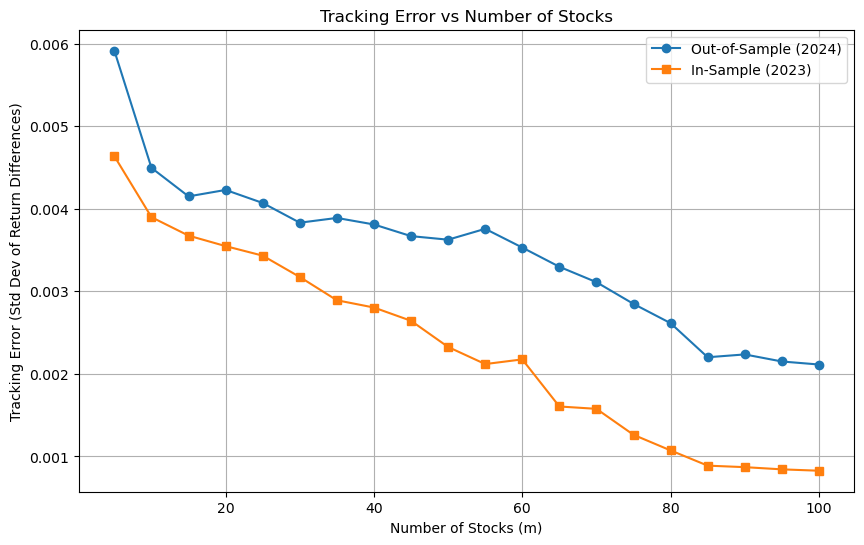

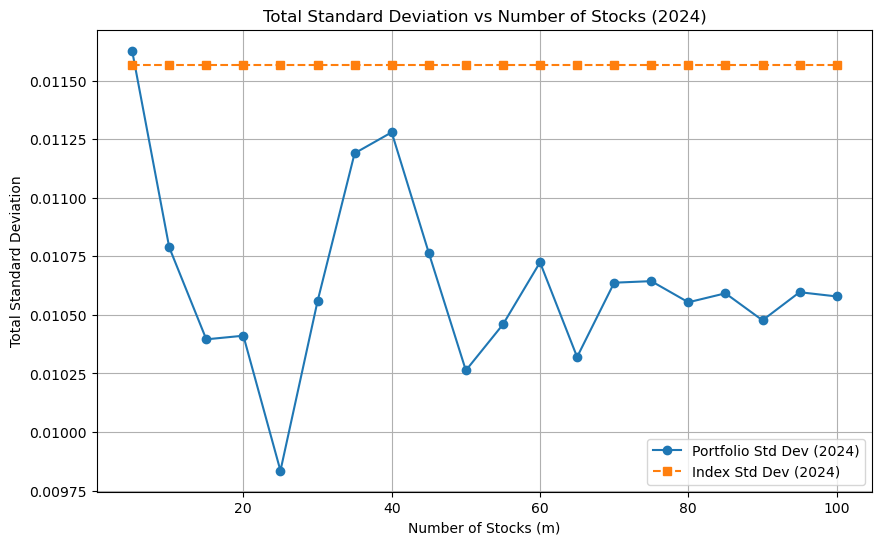

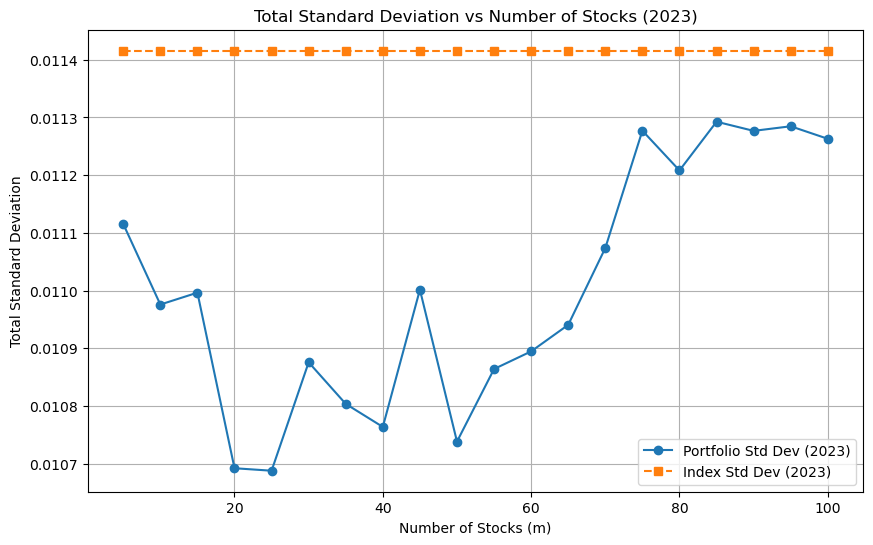

In [3]:
import matplotlib.pyplot as plt

# Lists to store m and metrics
m_values = range(5, 101, 5) 
tracking_errors_2024 = []
tracking_errors_2023 = []
std_devs_portfolio_2024 = []
std_devs_portfolio_2023 = []
std_devs_index_2024 = []
std_devs_index_2023 = []

# Loop over m values and collect metrics
for m in m_values:
    print(f"\nRunning fund_builder with m = {m}")
    results = fund_builder(m)
    tracking_errors_2024.append(results['tracking_error_2024'])
    tracking_errors_2023.append(results['tracking_error_2023'])
    std_devs_portfolio_2024.append(results['std_dev_portfolio_2024'])
    std_devs_portfolio_2023.append(results['std_dev_portfolio_2023'])
    std_devs_index_2024.append(results['std_dev_index_2024'])
    std_devs_index_2023.append(results['std_dev_index_2023'])

# Plot 1: Tracking Error vs Number of Stocks (m)
plt.figure(figsize=(10, 6))
plt.plot(m_values, tracking_errors_2024, marker='o', label='Out-of-Sample (2024)')
plt.plot(m_values, tracking_errors_2023, marker='s', label='In-Sample (2023)')
plt.xlabel('Number of Stocks (m)')
plt.ylabel('Tracking Error (Std Dev of Return Differences)')
plt.title('Tracking Error vs Number of Stocks')
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Total Standard Deviation vs Number of Stocks (m)
plt.figure(figsize=(10, 6))
plt.plot(m_values, std_devs_portfolio_2024, marker='o', label='Portfolio Std Dev (2024)')
plt.plot(m_values, std_devs_index_2024, marker='s', label='Index Std Dev (2024)', linestyle='--')
plt.xlabel('Number of Stocks (m)')
plt.ylabel('Total Standard Deviation')
plt.title('Total Standard Deviation vs Number of Stocks (2024)')
plt.grid(True)
plt.legend()
plt.show()

# Optionally, you can plot the 2023 standard deviations as well
plt.figure(figsize=(10, 6))
plt.plot(m_values, std_devs_portfolio_2023, marker='o', label='Portfolio Std Dev (2023)')
plt.plot(m_values, std_devs_index_2023, marker='s', label='Index Std Dev (2023)', linestyle='--')
plt.xlabel('Number of Stocks (m)')
plt.ylabel('Total Standard Deviation')
plt.title('Total Standard Deviation vs Number of Stocks (2023)')
plt.grid(True)
plt.legend()
plt.show()


## New Solution (Multiple Integer Programming)

### New Solution: Create the function to evaluate for any value of m 

In [1]:
def fund_builder_mip(num_stocks, time_limit):
    import pandas as pd
    import numpy as np
    import gurobipy as gp
    from gurobipy import GRB
    import os

    # Check if results file exists
    results_file = f'results_mip_m{num_stocks}.csv'
    if os.path.exists(results_file):
        print(f"Results file '{results_file}' already exists. Loading results.")
        results = pd.read_csv(results_file)
        print(results)

        selected_stocks = results['SelectedStocks'].tolist()
        weights = results['Weights'].tolist()
        portfolio_weights = dict(zip(selected_stocks, weights))
    else:
        # Read the 2023 and 2024 data
        data_2023 = pd.read_csv('2023data.csv')
        data_2024 = pd.read_csv('2024data.csv')

        # Set 'Date' column as index and ensure 'NDX' column exists
        data_2023.set_index('Date', inplace=True)
        data_2024.set_index('Date', inplace=True)

        if 'NDX' not in data_2023.columns or 'NDX' not in data_2024.columns:
            raise ValueError("NDX column (index) is missing from the data.")

        # Calculate daily returns and drop missing values
        returns_2023 = data_2023.pct_change().dropna(subset=['NDX'])
        returns_2024 = data_2024.pct_change().dropna(subset=['NDX'])

        # Separate index returns and stock returns
        index_returns_2023 = returns_2023['NDX']
        stock_returns_2023 = returns_2023.drop(columns=['NDX'])

        index_returns_2024 = returns_2024['NDX']
        stock_returns_2024 = returns_2024.drop(columns=['NDX'])

        # Get the list of stocks
        stocks = stock_returns_2023.columns.tolist()
        n = len(stocks)  # this should be 100

        # Number of stocks to select for the fund is m. Validate that m <= n
        m = min(num_stocks, n)

        # Formulate the MIP for weight selection with sparsity constraint
        model = gp.Model()

        # Decision variables
        w = model.addVars(stocks, lb=0.0, ub=1.0, name='w')  # Weights
        y = model.addVars(stocks, vtype=GRB.BINARY, name='y')  # Binary selection variables

        dates = index_returns_2023.index.tolist()
        z = model.addVars(dates, lb=0.0, name='z')  # Absolute deviations

        # Objective function: Minimize total absolute deviation
        model.setObjective(gp.quicksum(z[t] for t in dates), sense=GRB.MINIMIZE)

        # Constraints
        model.addConstr(gp.quicksum(w[i] for i in stocks) == 1, name='WeightsSumToOne')
        model.addConstr(gp.quicksum(y[i] for i in stocks) == m, name='Select_m_stocks')

        M = 1.0  # Big M value

        for i in stocks:
            model.addConstr(w[i] <= M * y[i], name=f'BigM_{i}')

        for t in dates:
            portfolio_return = gp.quicksum(w[i] * stock_returns_2023.loc[t, i] for i in stocks)
            index_return = index_returns_2023.loc[t]
            model.addConstr(z[t] >= index_return - portfolio_return, name=f'AbsDevPos_{t}')
            model.addConstr(z[t] >= portfolio_return - index_return, name=f'AbsDevNeg_{t}')

        # Set Gurobi parameters
        model.Params.OutputFlag = 0
        model.Params.TimeLimit = time_limit

        # Solve the MIP
        print(f"Optimizing MIP with m={m} and TimeLimit={time_limit} seconds...")
        model.optimize()

        # Check if optimization was successful
        if model.Status == GRB.OPTIMAL or model.Status == GRB.TIME_LIMIT:
            # Get the selected stocks and weights
            selected_stocks = [i for i in stocks if y[i].X > 0.5]
            portfolio_weights = {i: w[i].X for i in selected_stocks}

            print("\nSelected stocks and weights:")
            for stock in selected_stocks:
                print(f"{stock}: {portfolio_weights[stock]:.6f}")

            # Save results to CSV
            results = pd.DataFrame({
                'SelectedStocks': selected_stocks,
                'Weights': [portfolio_weights[i] for i in selected_stocks]
            })
            results.to_csv(results_file, index=False)
            print(f"\nResults saved to '{results_file}'.")
        else:
            print("Optimization was unsuccessful. No solution found within the time limit.")
            return None, None, None, None

    # Evaluate the portfolio performance in 2023 and 2024
    # Read the 2023 and 2024 data
    data_2023 = pd.read_csv('2023data.csv')
    data_2024 = pd.read_csv('2024data.csv')

    # Set 'Date' column as index
    data_2023.set_index('Date', inplace=True)
    data_2024.set_index('Date', inplace=True)

    # Calculate daily returns and drop missing values
    returns_2023 = data_2023.pct_change().dropna(subset=['NDX'])
    returns_2024 = data_2024.pct_change().dropna(subset=['NDX'])

    # Separate index returns and stock returns
    index_returns_2023 = returns_2023['NDX']
    stock_returns_2023 = returns_2023.drop(columns=['NDX'])

    index_returns_2024 = returns_2024['NDX']
    stock_returns_2024 = returns_2024.drop(columns=['NDX'])

    # Evaluate the portfolio performance in 2024 (out of sample)
    selected_stock_returns_2024 = stock_returns_2024[selected_stocks]
    portfolio_returns_2024 = selected_stock_returns_2024.mul(pd.Series(portfolio_weights), axis=1).sum(axis=1)

    # Calculate performance metrics for 2024
    common_dates_2024 = portfolio_returns_2024.index.intersection(index_returns_2024.index)
    return_diff_2024 = portfolio_returns_2024.loc[common_dates_2024] - index_returns_2024.loc[common_dates_2024]
    tracking_error_2024 = return_diff_2024.std()
    mean_abs_deviation_2024 = return_diff_2024.abs().mean()

    # Evaluate the portfolio performance in 2023 (in sample)
    selected_stock_returns_2023 = stock_returns_2023[selected_stocks]
    portfolio_returns_2023 = selected_stock_returns_2023.mul(pd.Series(portfolio_weights), axis=1).sum(axis=1)

    # Calculate performance metrics for 2023
    common_dates_2023 = portfolio_returns_2023.index.intersection(index_returns_2023.index)
    return_diff_2023 = portfolio_returns_2023.loc[common_dates_2023] - index_returns_2023.loc[common_dates_2023]
    tracking_error_2023 = return_diff_2023.std()
    mean_abs_deviation_2023 = return_diff_2023.abs().mean()

    print(f"\nPerformance in 2024:")
    print(f"Tracking Error (Std Dev of Return Differences): {tracking_error_2024:.6f}")
    print(f"Mean Absolute Deviation: {mean_abs_deviation_2024:.6f}")

    print(f"\nPerformance in 2023:")
    print(f"Tracking Error (Std Dev of Return Differences): {tracking_error_2023:.6f}")
    print(f"Mean Absolute Deviation: {mean_abs_deviation_2023:.6f}")

    return tracking_error_2024, mean_abs_deviation_2024, tracking_error_2023, mean_abs_deviation_2023


### New Solution: run for m = 5 - 100

In [2]:
time_limit = 3600 # change this value when grading 

m_list = [5,10,20,30,40,50,60,70,80,90,100]

for num_stocks in m_list:
    fund_builder_mip(num_stocks, time_limit)

Results file 'results_mip_m5.csv' already exists. Loading results.
  SelectedStocks   Weights
0           AMZN  0.155162
1           AAPL  0.271817
2           MSFT  0.247498
3           NXPI  0.186602
4            PEP  0.138920

Performance in 2024:
Tracking Error (Std Dev of Return Differences): 0.006086
Mean Absolute Deviation: 0.004506

Performance in 2023:
Tracking Error (Std Dev of Return Differences): 0.004408
Mean Absolute Deviation: 0.003056
Results file 'results_mip_m10.csv' already exists. Loading results.
  SelectedStocks   Weights
0          GOOGL  0.097537
1           AMZN  0.096679
2           AAPL  0.184490
3           CDNS  0.092834
4          CMCSA  0.069165
5           MSFT  0.135049
6           MDLZ  0.125809
7           NVDA  0.043328
8           NXPI  0.119619
9           TSLA  0.035488

Performance in 2024:
Tracking Error (Std Dev of Return Differences): 0.004918
Mean Absolute Deviation: 0.003519

Performance in 2023:
Tracking Error (Std Dev of Return Differences

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_60129/1093009966.py:115: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change().dropna(subset=['NDX'])
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_60129/1093009966.py:116: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change().dropna(subset=['NDX'])
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_60129/1093009966.py:115: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either

### New Solution: Plot Tracking Metrics

Results file 'results_mip_m10.csv' already exists. Loading results.
  SelectedStocks   Weights
0          GOOGL  0.097537
1           AMZN  0.096679
2           AAPL  0.184490
3           CDNS  0.092834
4          CMCSA  0.069165
5           MSFT  0.135049
6           MDLZ  0.125809
7           NVDA  0.043328
8           NXPI  0.119619
9           TSLA  0.035488

Performance in 2024:
Tracking Error (Std Dev of Return Differences): 0.004918
Mean Absolute Deviation: 0.003519

Performance in 2023:
Tracking Error (Std Dev of Return Differences): 0.003063
Mean Absolute Deviation: 0.001838
Results file 'results_mip_m20.csv' already exists. Loading results.
   SelectedStocks   Weights
0            ADBE  0.034608
1             AMD  0.015216
2           GOOGL  0.066790
3            AMZN  0.073023
4             ADI  0.072245
5            AAPL  0.108002
6            ASML  0.036065
7             ADP  0.050060
8             BKR  0.026806
9            BIIB  0.036370
10           AVGO  0.030112
11   

/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_60129/1093009966.py:115: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2023 = data_2023.pct_change().dropna(subset=['NDX'])
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_60129/1093009966.py:116: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = data_2024.pct_change().dropna(subset=['NDX'])
/var/folders/22/q2j3xwyd63q79r8qlb0118_h0000gn/T/ipykernel_60129/1093009966.py:115: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either

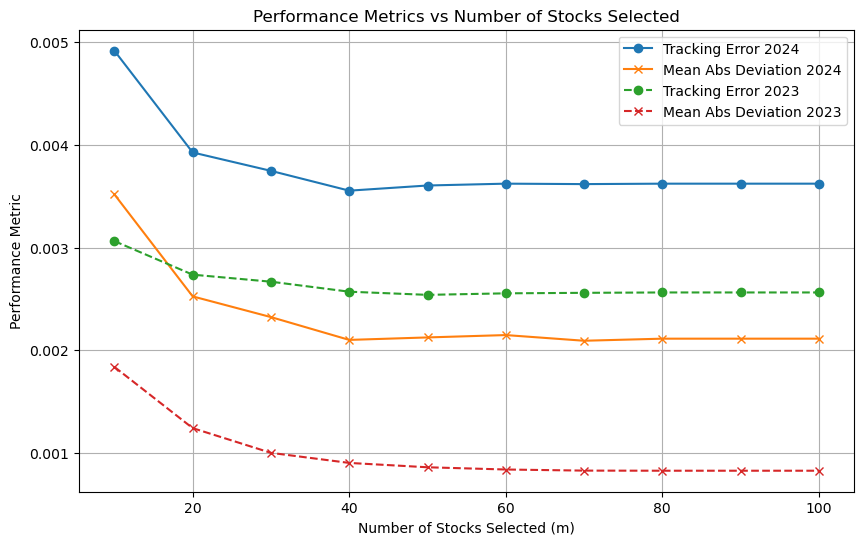

In [4]:
import matplotlib.pyplot as plt

# Define the range of m values
m_values = list(range(10, 101, 10))
tracking_errors_2024 = []
mean_abs_deviations_2024 = []
tracking_errors_2023 = []
mean_abs_deviations_2023 = []

# Loop over different m values
for m in m_values:
    te_2024, mad_2024, te_2023, mad_2023 = fund_builder_mip(num_stocks=m, time_limit=3600)
    if te_2024 is not None:
        tracking_errors_2024.append(te_2024)
        mean_abs_deviations_2024.append(mad_2024)
        tracking_errors_2023.append(te_2023)
        mean_abs_deviations_2023.append(mad_2023)
    else:
        tracking_errors_2024.append(None)
        mean_abs_deviations_2024.append(None)
        tracking_errors_2023.append(None)
        mean_abs_deviations_2023.append(None)

# Plot the tracking error and mean absolute deviation vs m
plt.figure(figsize=(10, 6))
plt.plot(m_values, tracking_errors_2024, marker='o', label='Tracking Error 2024')
plt.plot(m_values, mean_abs_deviations_2024, marker='x', label='Mean Abs Deviation 2024')
plt.plot(m_values, tracking_errors_2023, marker='o', linestyle='--', label='Tracking Error 2023')
plt.plot(m_values, mean_abs_deviations_2023, marker='x', linestyle='--', label='Mean Abs Deviation 2023')
plt.xlabel('Number of Stocks Selected (m)')
plt.ylabel('Performance Metric')
plt.title('Performance Metrics vs Number of Stocks Selected')
plt.legend()
plt.grid(True)
plt.show()
